# Transcription/degradation times ratio from constitutive exon read counts

Exploratory notebook for plotting constitutive exon read counts and related calculations.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import defaultdict
from dataclasses import dataclass
from pathlib import Path
from tqdm import tqdm
from typing import Optional


@dataclass
class GeneData:
    gene_name: str
    num_exons: int
    exon_reads: np.ndarray
    exon_locations: np.ndarray
    exon_lengths: np.ndarray
    effective_exon_lenghts: np.ndarray


def load_exon_data(preprocessed_data_folder: Path,
                   read_length: int = 150,
                   samples_to_use: Optional[list] = None) -> list[GeneData]:
    reads_df = pd.read_csv(preprocessed_data_folder / "aggregated_counts" / "constitutive_exon_counts.tsv",
                           sep='\t').set_index('constitutive_exon_id')
    if samples_to_use is not None:
        reads_df = reads_df[samples_to_use]

    def parse_gtf_attributes(attr_str):
        attrs = {}
        for field in attr_str.strip().rstrip(';').split(';'):
            field = field.strip()
            if not field:
                continue
            key, value = field.split(' ', 1)
            value = value.strip().strip('"')
            attrs[key] = value
        return attrs

    gtf_df = pd.read_csv(preprocessed_data_folder / "genomic_features/constitutive_exons.gtf",
                         comment='#',
                         names=['seqname', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame',
                                'attribute'],
                         delimiter="\t")

    gtf_df['length'] = gtf_df['end'] - gtf_df['start']

    const_exons_by_gene = defaultdict(list)
    for _, row in tqdm(gtf_df.iterrows(), total=len(gtf_df)):
        const_exon = parse_gtf_attributes(row['attribute'])
        const_exon['length'] = row['length']
        const_exon['reads'] = reads_df.loc[const_exon['constitutive_exon_id']].sum()
        const_exons_by_gene[const_exon['gene_id']].append(const_exon)

    gene_data_list: list[GeneData] = []
    for gene_name, const_exons in const_exons_by_gene.items():
        const_exons = sorted(const_exons, key=lambda x: x['number_in_gene_5_to_3_prime'])

        exon_lengths = np.asarray([float(exon['length']) for exon in const_exons])
        effective_exon_lenghts = exon_lengths + read_length
        geom_mean = np.exp(np.mean(np.log(effective_exon_lenghts)))
        effective_exon_lenghts /= geom_mean

        gene_data_list.append(GeneData(gene_name=gene_name,
                                       num_exons=len(const_exons),
                                       exon_reads=np.asarray([exon['reads'] for exon in const_exons]),
                                       exon_locations=np.asarray(
                                           [float(exon['mid_relative_5_to_3_prime']) for exon in const_exons]),
                                       exon_lengths=exon_lengths,
                                       effective_exon_lenghts=effective_exon_lenghts)
                              )

    gene_data_list = [gene_data for gene_data in gene_data_list if
                      gene_data.num_exons >= 2 and sum(gene_data.exon_reads) > 0]
    return gene_data_list

Load EU-seq dataset from Joris, intended only for illustration purpose now.

In [2]:
gene_data_list = load_exon_data(preprocessed_data_folder=Path(
    '/cellfile/projects/pol_ii_speed/jkoubele/analysis/EU_seq_Joris/results_const_exons/preprocessing/'))

/tmp/ipykernel_876517/654428054.py:40: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  gtf_df = pd.read_csv(preprocessed_data_folder / "genomic_features/constitutive_exons.gtf",
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 88581/88581 [00:15<00:00, 5849.95it/s]


# Example gene 1

Cherry picked gene with nice coverage to illustrate the estimation of the transcription/degradation times ratio (resp. the estimation of variable denoted $\pi$, representing fraction of currently transcribing transcripts in the dataset).

In [8]:
gene_data = [x for x in gene_data_list if x.gene_name == 'ENSG00000300218'][0]
output_folder = Path('./plots_constitutive_exons_examples')
output_folder.mkdir(exist_ok=True, parents=True)

In [11]:
print(f"{gene_data=}")

gene_data=GeneData(gene_name='ENSG00000300218', num_exons=3, exon_reads=array([231, 117,  63]), exon_locations=array([0.02730557, 0.31268593, 0.9878878 ]), exon_lengths=array([257., 143., 112.]), effective_exon_lenghts=array([1.29223045, 0.93027892, 0.83185351]))


### Plot coverage (read counts in different constitutive exons)

Plotted reads counts are divided by exon effective lengths (the effective lengths are divided by their geometrics mean in the gene to make their values lie around 1).

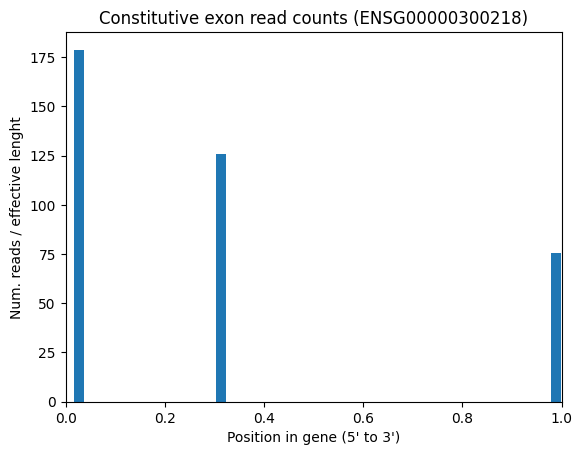

In [9]:
plt.bar(x=gene_data.exon_locations,
        height=gene_data.exon_reads / gene_data.effective_exon_lenghts,
        width=0.02)

plt.title(f'Constitutive exon read counts ({gene_data.gene_name})')
plt.xlabel("Position in gene (5' to 3')")
plt.ylabel("Num. reads / effective lenght")
plt.xlim(0.0, 1.0)
plt.savefig(output_folder / f'read_counts_{gene_data.gene_name}.png',
            dpi=200,
            bbox_inches='tight')
plt.show()

### Plot loss function

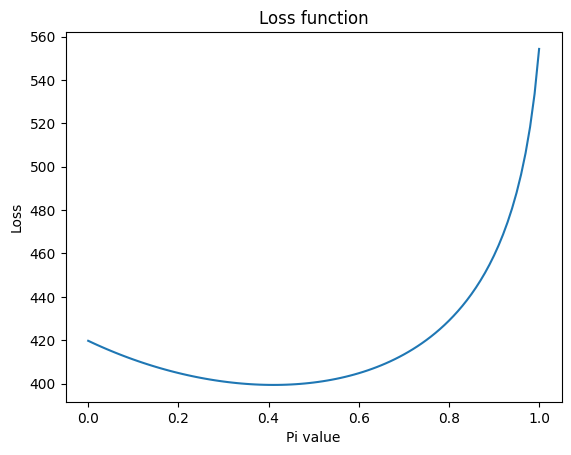

In [5]:
pi_values = np.linspace(0.0, 1.0, 101)[:, np.newaxis]  # shape (101, 1)

trapezoid_density = 1 + pi_values - 2 * gene_data.exon_locations[np.newaxis, :] * pi_values
unnormalized_probability = trapezoid_density * gene_data.effective_exon_lenghts[np.newaxis, :]

probability = unnormalized_probability / unnormalized_probability.sum(axis=1, keepdims=True)
loss = np.dot(-np.log(probability), gene_data.exon_reads)

pi_values = pi_values.squeeze()

plt.plot(pi_values, loss)
plt.title('Loss function')
plt.xlabel('Pi value')
plt.ylabel('Loss')
plt.savefig(output_folder / f'loss_{gene_data.gene_name}.png',
            dpi=200,
            bbox_inches='tight')
plt.show()

### Plot posterior distribution
- We are assuming uniform prior for now (otherwise we need to scale posterior by the prior).
- Posterior is a discrete distribution over sampled values of $\pi$.

map_estimate=0.41000000000000003
posterior_mean=0.408236406471663


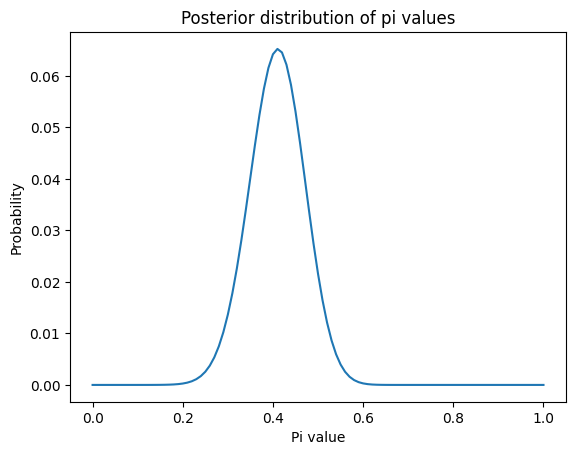

In [6]:
unnormalized_posterior = np.exp(-loss)
unnormalized_posterior /= unnormalized_posterior.max()
posterior = unnormalized_posterior / np.sum(unnormalized_posterior)

map_estimate = pi_values[posterior.argmax()]
posterior_mean = np.dot(posterior, pi_values)

print(f"{map_estimate=}")
print(f"{posterior_mean=}")

plt.plot(pi_values, posterior)
plt.title('Posterior distribution of pi values')
plt.xlabel('Pi value')
plt.ylabel('Probability')
plt.savefig(output_folder / f'posterior_{gene_data.gene_name}.png',
            dpi=200,
            bbox_inches='tight')
plt.show()

## Example gene 2

Example where the observed coverage is increasing (from 5' to 3'); same plots as above.

gene_data=GeneData(gene_name='ENSG00000177757', num_exons=2, exon_reads=array([11, 34]), exon_locations=array([0.16915323, 0.77399194]), exon_lengths=array([ 839., 1119.]), effective_exon_lenghts=array([0.88281018, 1.13274633]))


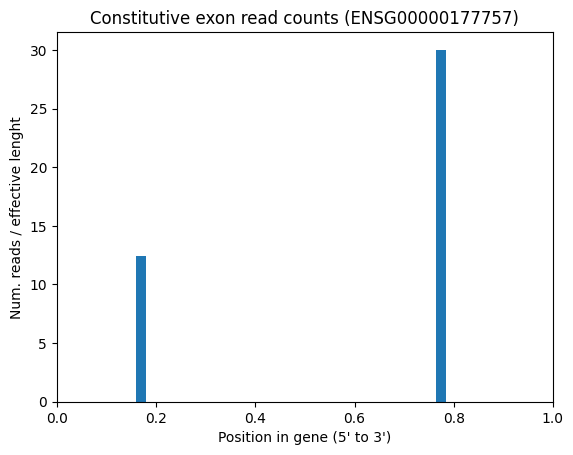

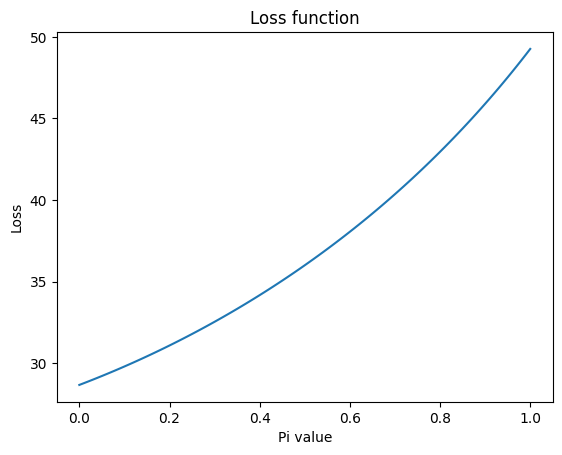

map_estimate=0.0
posterior_mean=0.07349551397899198


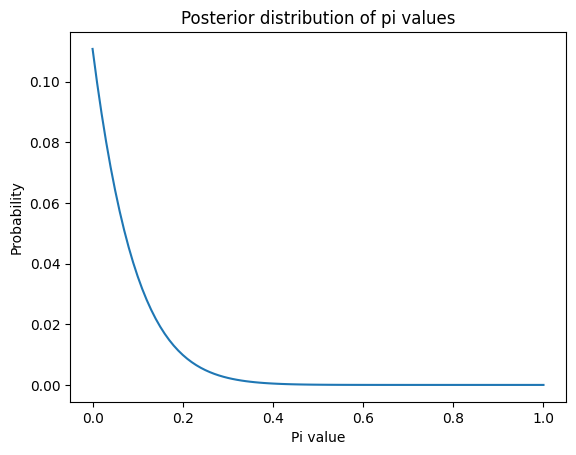

In [12]:
gene_data = [x for x in gene_data_list if x.gene_name == 'ENSG00000177757'][0]
print(f"{gene_data=}")

plt.bar(x=gene_data.exon_locations,
        height=gene_data.exon_reads / gene_data.effective_exon_lenghts,
        width=0.02)

plt.title(f'Constitutive exon read counts ({gene_data.gene_name})')
plt.xlabel("Position in gene (5' to 3')")
plt.ylabel("Num. reads / effective lenght")
plt.xlim(0.0, 1.0)
plt.savefig(output_folder / f'read_counts_{gene_data.gene_name}.png',
            dpi=200,
            bbox_inches='tight')
plt.show()


pi_values = np.linspace(0.0, 1.0, 101)[:, np.newaxis]  # shape (101, 1)
trapezoid_density = 1 + pi_values - 2 * gene_data.exon_locations[np.newaxis, :] * pi_values
unnormalized_probability = trapezoid_density * gene_data.effective_exon_lenghts[np.newaxis, :]

probability = unnormalized_probability / unnormalized_probability.sum(axis=1, keepdims=True)
loss = np.dot(-np.log(probability), gene_data.exon_reads)

pi_values = pi_values.squeeze()

plt.plot(pi_values, loss)
plt.title(f'Loss function ({gene_data.gene_name})')
plt.xlabel('Pi value')
plt.ylabel('Loss')
plt.savefig(output_folder / f'loss_{gene_data.gene_name}.png',
            dpi=200,
            bbox_inches='tight')
plt.show()

unnormalized_posterior = np.exp(-loss)
unnormalized_posterior /= unnormalized_posterior.max()
posterior = unnormalized_posterior / np.sum(unnormalized_posterior)

map_estimate = pi_values[posterior.argmax()]
posterior_mean = np.dot(posterior, pi_values)

print(f"{map_estimate=}")
print(f"{posterior_mean=}")

plt.plot(pi_values, posterior)
plt.title(f'Posterior distribution of pi values ({gene_data.gene_name})')
plt.xlabel('Pi value')
plt.ylabel('Probability')
plt.savefig(output_folder / f'posterior_{gene_data.gene_name}.png',
            dpi=200,
            bbox_inches='tight')
plt.show()

## Summary across genes in datasets
We will now estimate $\pi$ via MLE for each gene in a dataset, and summarize on dataset level.

In [29]:
def estimate_pi_by_mle(gene_data: GeneData) -> Optional[float]:
    pi_values = np.linspace(0.0, 1.0, 101)[:, np.newaxis]  # shape (101, 1)
    trapezoid_density = 1 + pi_values - 2 * gene_data.exon_locations[np.newaxis, :] * pi_values
    unnormalized_probability = trapezoid_density * gene_data.effective_exon_lenghts[np.newaxis, :]

    probability = unnormalized_probability / unnormalized_probability.sum(axis=1, keepdims=True)
    loss = np.dot(-np.log(probability), gene_data.exon_reads)    
    if np.all(loss == loss[0]):
        return None
    pi_values = pi_values.squeeze()
    pi_mle = pi_values[loss.argmin()]
    return pi_mle

pi_estimates = [estimate_pi_by_mle(gene_data) for gene_data in tqdm(gene_data_list)]
pi_estimates = np.asarray([pi for pi in pi_estimates if pi is not None])
len(pi_estimates)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 9565/9565 [00:00<00:00, 10148.47it/s]


9565

In [43]:
@dataclass
class Dataset:
    dataset_name: str
    gene_data_list: list[GeneData]
    

datasets = [Dataset("Mouse Kidney",
             load_exon_data(Path("/cellfile/projects/pol_ii_speed/jkoubele/analysis/mouse_kidney_age_dr/results/preprocessing/"))),
           Dataset("Mouse Liver",
             load_exon_data(Path("/cellfile/projects/pol_ii_speed/jkoubele/analysis/mouse_age_dr/results_const_exons/preprocessing/"))),
            Dataset("EU seq from Joris",
             load_exon_data(Path("/cellfile/projects/pol_ii_speed/jkoubele/analysis/EU_seq_Joris/results_const_exons/preprocessing/")))]



/tmp/ipykernel_876517/654428054.py:40: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  gtf_df = pd.read_csv(preprocessed_data_folder / "genomic_features/constitutive_exons.gtf",
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 115895/115895 [00:20<00:00, 5706.38it/s]
/tmp/ipykernel_876517/654428054.py:40: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  gtf_df = pd.read_csv(preprocessed_data_folder / "genomic_features/constitutive_exons.gtf",
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 115895/115895 [00:19<00:00, 6061.67it/s]
/tmp/ipykernel_876517/654428054.py:40: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  gtf_df = pd.read_csv(preprocessed_data_folder / "genomic_features/constitutive_exons.gtf",
10

--------------------------------------------------
Mouse Kidney


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 14995/14995 [00:01<00:00, 10529.55it/s]


14995


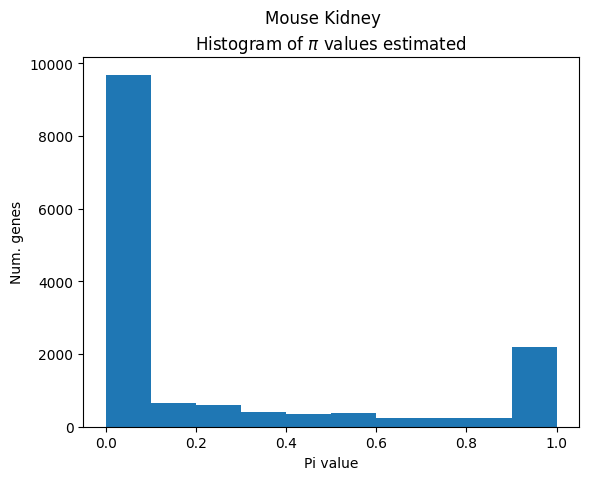

9053, 0.6037345781927309
2027, 0.1351783927975992
3915, 0.2610870290096699
--------------------------------------------------
Mouse Liver


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 11799/11799 [00:01<00:00, 10199.72it/s]


11799


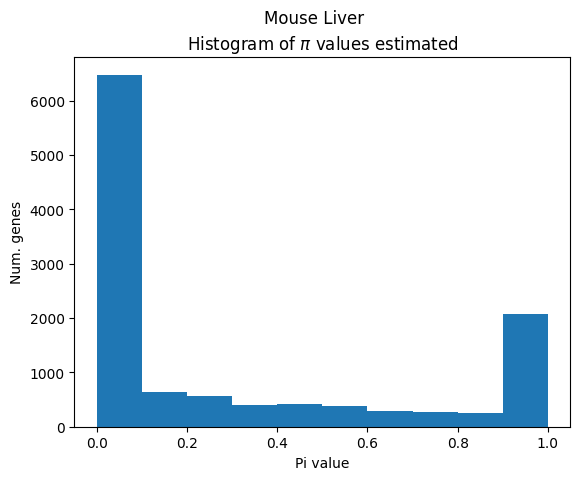

5897, 0.4997881176370879
1864, 0.1579794897872701
4038, 0.34223239257564203
--------------------------------------------------
EU seq from Joris


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 9565/9565 [00:00<00:00, 10335.93it/s]


9565


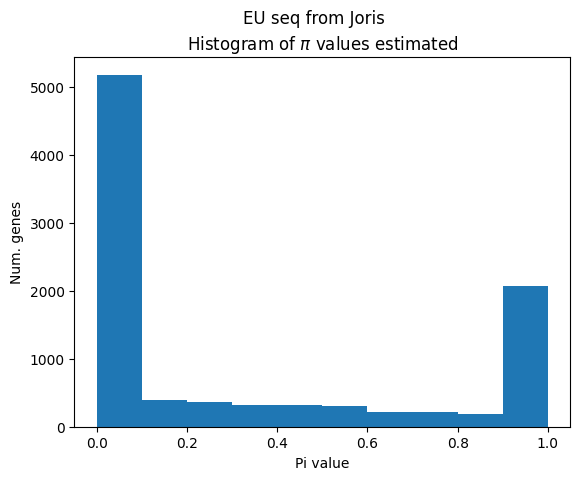

4826, 0.5045478306325144
1873, 0.19581808677469942
2866, 0.2996340825927862


In [58]:
def estimate_pi_by_mle(gene_data: GeneData) -> Optional[float]:
    pi_values = np.linspace(0.0, 1.0, 101)[:, np.newaxis]  # shape (101, 1)
    trapezoid_density = 1 + pi_values - 2 * gene_data.exon_locations[np.newaxis, :] * pi_values
    unnormalized_probability = trapezoid_density * gene_data.effective_exon_lenghts[np.newaxis, :]

    probability = unnormalized_probability / unnormalized_probability.sum(axis=1, keepdims=True)
    loss = np.dot(-np.log(probability), gene_data.exon_reads)    
    if np.all(loss == loss[0]):
        return None
    pi_values = pi_values.squeeze()
    pi_mle = pi_values[loss.argmin()]
    return pi_mle

for dataset in datasets:
    print(50*'-')
    print(dataset.dataset_name)
    pi_estimates = [estimate_pi_by_mle(gene_data) for gene_data in tqdm(dataset.gene_data_list)]
    pi_estimates = np.asarray([pi for pi in pi_estimates if pi is not None])
    print(len(pi_estimates))

    plt.hist(pi_estimates)
    plt.title(f'Histogram of $\pi$ values estimated')
    plt.suptitle(f'{dataset.dataset_name}')
    plt.xlabel('Pi value')
    plt.ylabel('Num. genes')
    plt.savefig(output_folder / f'pi_values_histogram_{dataset.dataset_name.replace(" ", "_")}.png',
            dpi=200,
            bbox_inches='tight')
    plt.show()
    print(f"{sum(pi_estimates == 0)}, {sum(pi_estimates == 0) / len(pi_estimates)}")
    print(f"{sum(pi_estimates == 1)}, {sum(pi_estimates == 1) / len(pi_estimates)}")
    print(f"{np.sum((0 < pi_estimates) & (pi_estimates < 1))}, {np.sum((0 < pi_estimates) & (pi_estimates < 1)) / len(pi_estimates)}")